# Image Similarity Search with VGG16 and Cosine Similarity

[Youtube-Video](https://www.youtube.com/watch?v=dCcRWdmmgA0)

cutoff VGG16 at the last convolutional layer/max pooling layer

- takes an image and outputs a 512-number vector
- all database images are converted to 512-number vectors and stored
- when you query, that image also becomes a 512-number vector

- features are extracted from all images in a directory
- these features are stored in a HDF5 file along with image names

## How to compare feature vectors?

Cosine Similarity can be used to compare feature vectors

- cosine similarity compares how "aligned" two vectors are (like comparing directions they point) (Note: we can also use L2 distance, anything that quantifies distance can be used)
- measures the cosine of the angle between two vectors:  

  - Formula: $cos(\theta) = \frac{A \cdot B}{||A|| \cdot ||B||}$
- result ranges from -1 (opposite) to 1 (identical)
- value of 0 indicates perpendicularity (no similarity)
- we can't visualize 512-dimensional vectors, so map them to 3 most important dimensions using PCA (Principal Component Analysis)
- Faiss is more efficient - instead of comparing with every vector, we create an efficient index structure

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

import numpy as np
from numpy import linalg as LA

In [3]:
gpu = len(tf.config.list_physical_devices("GPU")) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [4]:
# Understand the VGG16 model.
model = VGG16(weights = 'imagenet',
              input_shape = ((224, 224, 3)),
              pooling = 'max',
              include_top = False)
model.summary()
# See how the final output gives us a vector of size 512


2025-01-20 17:47:48.285746: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-20 17:47:48.285771: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-20 17:47:48.285774: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-20 17:47:48.285787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-20 17:47:48.285798: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class VGGNet:
    def __init__(self):
        # weights: 'imagenet'
        # pooling: 'max' or 'avg'
        # input_shape: (width, height, 3), width and height should >= 48
        self.input_shape = (224, 224, 3)
        self.weight = "imagenet"
        self.pooling = "max"
        self.model = VGG16(
            weights=self.weight,
            input_shape=(self.input_shape[0], self.input_shape[1], self.input_shape[2]),
            pooling=self.pooling,
            include_top=False,
        )
        self.model.predict(np.zeros((1, 224, 224, 3)))

    """
    Use vgg16 model to extract features
    Output normalized feature vector
    """

    def extract_feat(self, img_path):
        img = image.load_img(
            img_path, target_size=(self.input_shape[0], self.input_shape[1])
        )
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feat = self.model.predict(img)
        norm_feat = feat[0] / LA.norm(feat[0])
        return norm_feat

This code will read images from a specified directory and extracts features using a pre-trained VGG16 network on Imagenet database. The final output for the feature vector is 512. These features from every image in the input folder are captured into a hdf5 file. This file will be imported to search for similar images to a query image by comparing the feature vectors.

In [6]:
import os
import h5py

In [7]:
from PIL import Image

images_path = "../data/renamed_dub_removed/"
img_list = []
for f in os.listdir(images_path):
    # Skip JSON files
    if f.endswith(".json"):
        continue
    if f.endswith(".txt"):
        continue
    if f.endswith(".DS_Store"):
        continue
        
    try:
        img_path = os.path.join(images_path, f)
        # Check if file is actually a JPEG using PIL
        with Image.open(img_path) as img:
            # Verify it's a JPEG and has the correct number of channels for VGG16
            if img.format == "JPEG" and img.mode == "RGB":
                img_list.append(img_path)
    except Exception as e:
        print(f"Error processing {f}: {str(e)}")
        continue

print(f"Found {len(img_list)} valid JPEG images")

Found 1743 valid JPEG images


In [ ]:
print("Starting feature extraction...")

model = VGGNet()
feats = []
names = []

for img_path in img_list:  # use the validated img_list instead of os.listdir
    img_name = os.path.basename(img_path)
#    print(f"Extracting features from image - {img_name}")
    
    try:
        feat = model.extract_feat(img_path)
        feats.append(feat)
        names.append(img_name)
    except Exception as e:
        print(f"Error processing {img_name}: {str(e)}")
        continue

feats = np.array(feats)

# directory for storing extracted features
output = "CNNFeatures.h5"

print("Writing feature extraction results to h5 file...")

h5f = h5py.File(output, "w")
h5f.create_dataset("dataset_1", data=feats)
h5f.create_dataset("dataset_2", data=np.string_(names))  
h5f.close()

print(f"Successfully processed {len(names)} images")

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [10]:
import numpy as np
import h5py

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Top 10 matches with similarity scores:
1. Image: american_staffordshire_terrier_0001.jpg, Score: 1.0000
2. Image: american_staffordshire_terrier_0044.jpg, Score: 0.7943
3. Image: american_staffordshire_terrier_0017.jpg, Score: 0.7885
4. Image: american_pit_bull_terrier_0004.jpg, Score: 0.7874
5. Image: american_pit_bull_terrier_0007.jpg, Score: 0.7865
6. Image: american_staffordshire_terrier_0124.jpg, Score: 0.7836
7. Image: american_staffordshire_terrier_0069.jpg, Score: 0.7797
8. Image: bull_mastiff_0153.jpg, Score: 0.7652
9. Image: american_staffordshire_terrier_0120.jpg, Score: 0.7637
10. Image: staffordshire_bullterrier_0010.jpg, Score: 0.7635


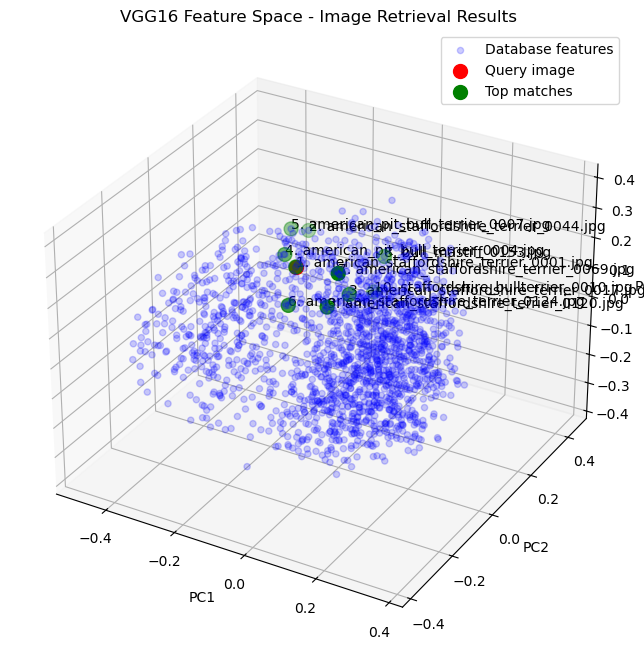

In [20]:
def plot_feature_space(
    features, query_feat, top_matches, imgNames, title="Feature Space Visualization"
):
    """Visualize high-dimensional features in 3D using PCA"""
    # Apply PCA to reduce dimensions to 3
    pca = PCA(n_components=3)
    # Combine query and database features
    all_features = np.vstack([features, query_feat.reshape(1, -1)])
    features_3d = pca.fit_transform(all_features)

    # Split back into database and query
    db_features_3d = features_3d[:-1]
    query_feature_3d = features_3d[-1]

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Plot all database points
    ax.scatter(
        db_features_3d[:, 0],
        db_features_3d[:, 1],
        db_features_3d[:, 2],
        c="blue",
        alpha=0.2,
        label="Database features",
    )

    # Plot query point
    ax.scatter(
        query_feature_3d[0],
        query_feature_3d[1],
        query_feature_3d[2],
        c="red",
        s=100,
        label="Query image",
    )

    # Plot top matches
    matches_3d = db_features_3d[top_matches]
    ax.scatter(
        matches_3d[:, 0],
        matches_3d[:, 1],
        matches_3d[:, 2],
        c="green",
        s=100,
        label="Top matches",
    )

    # Add labels for top matches
    for i, match_idx in enumerate(top_matches):
        img_name = (
            imgNames[match_idx].decode("utf-8")
            if isinstance(imgNames[match_idx], bytes)
            else imgNames[match_idx]
        )
        ax.text(
            matches_3d[i, 0], matches_3d[i, 1], matches_3d[i, 2], f"{i + 1}. {img_name}"
        )

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(title)
    ax.legend()
    plt.show()


# Your existing code...
h5f = h5py.File("CNNFeatures.h5", "r")
feats = h5f["dataset_1"][:]
imgNames = h5f["dataset_2"][:]
h5f.close()

queryImg = "../data/renamed_dub_removed/american_staffordshire_terrier_0001.jpg"
model = VGGNet()
query_feat = model.extract_feat(queryImg)

scores = []
from scipy import spatial

for i in range(feats.shape[0]):
    score = 1 - spatial.distance.cosine(query_feat, feats[i])
    scores.append(score)
scores = np.array(scores)
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]

# Get top 10 matches
top_n = 10
top_matches = rank_ID[:top_n]
top_scores = rank_score[:top_n]

# Print matches
print(f"Top {top_n} matches with similarity scores:")
for i, (image_id, score) in enumerate(zip(top_matches, top_scores)):
    image_name = (
        imgNames[image_id].decode("utf-8")
        if isinstance(imgNames[image_id], bytes)
        else imgNames[image_id]
    )
    print(f"{i + 1}. Image: {image_name}, Score: {score:.4f}")

# Visualize feature space
plot_feature_space(
    feats,
    query_feat,
    top_matches,
    imgNames,
    "VGG16 Feature Space - Image Retrieval Results",
)
